## Goal: Using info from Notes.md, quickly make model

Speed - use chat

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [43]:
DIRECTORY = '/kaggle/input/rohlik-sales-forecasting-challenge-v2/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date']).sort_values(by=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date']).sort_values(by=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date']).sort_values(by=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [44]:
# 1. Calendar Features
calendar = calendar.sort_values(['warehouse', 'date'])

calendar['day_before_holiday'] = calendar.groupby('warehouse')['holiday'].shift(-1).fillna(0) == 1
calendar['day_after_holiday'] = calendar.groupby('warehouse')['holiday'].shift(1).fillna(0) == 1
calendar['day_before_shop_closed'] = calendar.groupby('warehouse')['shops_closed'].shift(-1).fillna(0) == 1
calendar['day_after_shop_closed'] = calendar.groupby('warehouse')['shops_closed'].shift(1).fillna(0) == 1

# For each warehouse, forward-fill to get the previous holiday date
calendar['prev_holiday_date'] = calendar.groupby('warehouse')['date'].transform(
    lambda s: s.where(calendar.loc[s.index, 'holiday'] == 1).ffill()
)
calendar['days_after_previous_holiday'] = (calendar['date'] - calendar['prev_holiday_date']).dt.days
calendar = calendar.drop(columns='prev_holiday_date')

# For each warehouse, backward-fill to get the next holiday date
calendar['next_holiday_date'] = calendar.groupby('warehouse')['date'].transform(
    lambda s: s.where(calendar.loc[s.index, 'holiday'] == 1).bfill()
)
calendar['days_until_next_holiday'] = (calendar['next_holiday_date'] - calendar['date']).dt.days
calendar = calendar.drop(columns='next_holiday_date')

# For each warehouse, forward-fill to get the previous shops closed date
calendar['prev_shops_closed_date'] = calendar.groupby('warehouse')['date'].transform(
    lambda s: s.where(calendar.loc[s.index, 'shops_closed'] == 1).ffill()
)
calendar['days_after_previous_shops_closed'] = (calendar['date'] - calendar['prev_shops_closed_date']).dt.days
calendar = calendar.drop(columns='prev_shops_closed_date')

# For each warehouse, backward-fill to get the next shops closed date
calendar['next_shops_closed_date'] = calendar.groupby('warehouse')['date'].transform(
    lambda s: s.where(calendar.loc[s.index, 'shops_closed'] == 1).bfill()
)
calendar['days_until_next_shops_closed'] = (calendar['next_shops_closed_date'] - calendar['date']).dt.days
calendar = calendar.drop(columns='next_shops_closed_date')

In [45]:
# 2. Count + Discount Features

train_merged = train.merge(inventory, on=['unique_id', 'warehouse'], how='left')\
                    .merge(calendar.drop(columns=['winter_school_holidays', 'school_holidays']), on=['date', 'warehouse'], how='left')

train_merged['common_name'] = train_merged['name'].str.split('_').str[0]
discount_cols = [col for col in train_merged.columns if 'discount' in col]
train_merged['max_discount'] = train_merged[discount_cols].max(axis=1)
train_merged['num_items_same_common'] = train_merged.groupby(['warehouse', 'common_name'])['name'].transform('count')
train_merged['row_discount_mean'] = train_merged[discount_cols].mean(axis=1)
train_merged['discount_average'] = train_merged.groupby(['unique_id'])['row_discount_mean'].transform('mean')
train_merged['discount_zs'] = train_merged['row_discount_mean'] - train_merged['discount_average']
train_merged['num_warehouses'] = train_merged.groupby('product_unique_id')['warehouse'].transform('nunique')


In [46]:
# 3. EMA Feature
train_end = train_merged['date'].max() - pd.Timedelta('13D')
val_sales = train_merged.loc[(train_merged['date'] > train_end) & (train_merged['date'] < pd.to_datetime('2024-06-03')), 'sales'] # save val sales

In [47]:
train_merged = train_merged[train_merged['sales'].notna()]
train_merged.loc[train_merged['date'] > train_end, 'sales'] = np.nan
train_merged['sales_ema'] = train_merged.groupby('unique_id')['sales'] \
    .transform(lambda x: x.ewm(alpha=0.005, adjust=False).mean().shift(1))
train_merged['sales_ema_common'] = train_merged.groupby(['date', 'common_name'])['sales_ema'].transform('sum')

# train_merged['shift14d'] = train_merged.groupby('unique_id')['sales'].shift(14)
# train_merged['shift30d'] = train_merged.groupby('unique_id')['sales'].shift(30)
# train_merged['shift14d_rolling7'] = train_merged.groupby('unique_id')['shift14d'].rolling(7).mean().reset_index(level=0, drop=True)

In [48]:
# Clean dataset
object_cols = train_merged.select_dtypes(include=['object']).columns
train_merged[object_cols] = train_merged[object_cols].astype('category')

train_merged['noise_normal'] = np.random.normal(loc=0, scale=1, size=len(train_merged))
train_merged['noise_uniform'] = np.random.uniform(low=0, high=1, size=len(train_merged))

In [62]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

train_mask = (train_merged['date'] >= pd.to_datetime('2022-01-01')) & (train_merged['date'] <= train_end)
valid_mask = (train_merged['date'] > train_end) & (train_merged['date'] < pd.to_datetime('2024-06-03'))

train_data = train_merged.loc[train_mask].copy()
train_data = train_data[train_data['sales'].notna()]
valid_data = train_merged.loc[valid_mask].copy()

features = [col for col in train_merged.columns if col not in ['date', 'sales']]

# Set up model parameters analogous to the LightGBM settings
# Note: In xgboost, "colsample_bytree" is equivalent to LightGBM's "feature_fraction"
params = {
    'learning_rate': 0.05,
    # 'colsample_bytree': 0.8,
    # 'reg_lambda': 1.0,
    # 'reg_alpha': 0.0,
    'seed': 42,
    'device':'cuda',
    'enable_categorical':True
}

# Create an XGBRegressor model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000,  # large number; early stopping will determine the actual number of trees
    **params
)

# Train the model with early stopping on the validation set.
# The eval_metric is set to 'mae' to track Mean Absolute Error during training.
model.fit(
    train_data[features],
    np.sqrt(train_data['sales']),
    eval_set=[(valid_data[features], np.sqrt(val_sales))],
    early_stopping_rounds=100,
    verbose=100,
    eval_metric='mse'
)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoostError: [21:58:36] /workspace/src/metric/metric.cc:49: Unknown metric function mse
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x1ba24e) [0x7f7a105fe24e]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4f7e7e) [0x7f7a1093be7e]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4ccdd3) [0x7f7a10910dd3]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterBoostedRounds+0x32) [0x7f7a105a14d2]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f7c05973e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f7c05970493]
  [bt] (6) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f7c0599a3e9]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x7f7c05999a00]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x25b) [0x55e8a200cb4b]



In [41]:
# # Train lgbm model
# train_mask = (train_merged['date'] >= pd.to_datetime('2022-01-01')) & (train_merged['date'] <= train_end)
# valid_mask = (train_merged['date'] > train_end) & (train_merged['date'] < pd.to_datetime('2024-06-03'))

# train_data = train_merged.loc[train_mask].copy()
# train_data = train_data[train_data['sales'].notna()]
# valid_data = train_merged.loc[valid_mask].copy()

# # Define features (exclude target and date; adjust if you need to drop additional columns)
# features = [col for col in train_merged.columns if col not in ['date', 'sales']]

# # Create LightGBM Datasets
# lgb_train = lgb.Dataset(train_data[features], label=train_data['sales'])
# lgb_valid = lgb.Dataset(valid_data[features], label=val_sales, reference=lgb_train)

# # Define LightGBM parameters (you can adjust these)
# params = {
#     'objective': 'regression',
#     'metric': 'mae',
#     'boosting': 'gbdt',
#     'verbosity': -1,
#     'seed': 40,
#     'max_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.8, 
#     # 'reg_lambda': 0.5,
#     # 'reg_alpha': 0.5,
#     'verbosity': -1,
#     'device': 'gpu', 
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
#     'max_bins': 255
# }

# # Train the model with early stopping
# model = lgb.train(
#     params,
#     lgb_train,
#     num_boost_round=5000,
#     valid_sets=[lgb_train, lgb_valid],
#     valid_names=['train', 'valid'],
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(period=100)
#     ]
# )

Training until validation scores don't improve for 100 rounds
[100]	train's l1: 29.3644	valid's l1: 32.9555
[200]	train's l1: 27.4964	valid's l1: 31.6895
[300]	train's l1: 26.679	valid's l1: 31.2841


KeyboardInterrupt: 

In [61]:
from sklearn.metrics import mean_absolute_error

# Predict on the train set using the best iteration
train_preds = model.predict(train_data[features])
# Predict on the test set using the best iteration (we already computed this as 'predictions' before)
valid_preds = model.predict(valid_data[features])

# Compute the MAE for the train and test sets
train_mae = mean_absolute_error(train_data['sales'], train_preds)
test_mae = mean_absolute_error(val_sales.fillna(0), valid_preds)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 95.8575
Test MAE: 106.7987


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

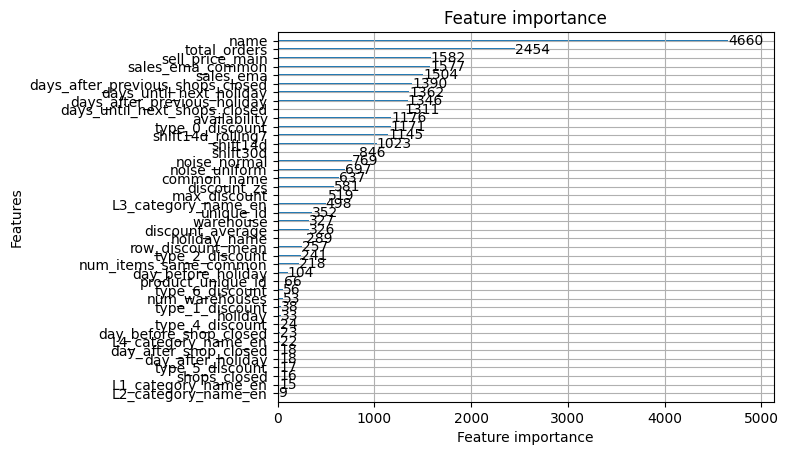

In [264]:
lgb.plot_importance(model)